# Protein Folding Problem

## content

[i.ProteinFoldingProblem function](#i.ProteinFoldingProblemfunction)<br>
&nbsp; [1.ProteinDefining](#1.ProteinDefining)<br>
&nbsp; [2.InteractionMethod](#2.InteractionMethod)<br>
&nbsp; [3.PenaltyTerms](#3.PenaltyTerms)<br>
[ii.ConvertToQubits](#ii.ConvertToQubits)<br>
[iii.VQEwithCVaRexpectation](#iii.VQEwithCVaRexpectation)<br>
[iv.AnalysingTheResults](#iv.AnalysingTheResults)<br>


In [1]:
from qiskit_nature.problems.sampling.protein_folding.peptide.peptide import Peptide
from qiskit_nature.problems.sampling.protein_folding.interactions.miyazawa_jernigan_interaction import MiyazawaJerniganInteraction
from qiskit_nature.problems.sampling.protein_folding.penalty_parameters import PenaltyParameters
from qiskit_nature.problems.sampling.protein_folding.protein_folding_problem import ProteinFoldingProblem
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit import execute, Aer
from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit.algorithms import VQE
from pathlib import Path
import os
import numpy as np
from typing import Tuple, List

##  i.ProteinFoldingProblemfunction

We can define a protein folding function to solve this problem based on:
1. Definition of a protein
2. The interaction method
3. Penalty terms


### 1.ProteinDefining

In [2]:
#main_chain
residue_sequence = "APRLRFY" #Alanine,Proline,Arginine,Leucine,Arginine,Phenylalanine,Tyrosine / 7 amino acids

In [3]:
def validate_residue_sequence(residue_sequence: str):
    for residue_symbol in residue_sequence:
        if validate_residue_symbol(residue_symbol) == False:
            return False
    return True


def validate_residue_symbol(residue_symbol: str) -> bool:
    valid_residues = [
        "A",  # Alanine
        "C",  # Cysteine
        "D",  # Aspartic acid
        "E",  # Glutamic acid
        "F",  # Phenylalanine
        "G",  # Glycine
        "H",  # Histidine
        "I",  # Isoleucine
        "K",  # Lysine
        "L",  # Leucine
        "M",  # Methionine
        "N",  # Asparagine
        "P",  # Proline
        "Q",  # Glutamine
        "R",  # Arginine
        "S",  # Serine
        "T",  # Threonine
        "V",  # Valine
        "W",  # Tryptophan
        "Y",  # Tyrosine
    ]
    if residue_symbol != "" and residue_symbol not in valid_residues:
        return False
    return True


In [4]:
validate_residue_sequence(residue_sequence)

True

### 2.InteractionMethod

In [6]:
def construct_resource_path():
    current_path = Path().parent.absolute()
    resource_relative_path = Path("resources")
    current_path = os.path.join(current_path, resource_relative_path)
    filename = "mj_matrix.txt"
    path = os.path.normpath(os.path.join(current_path, filename))
    return path

def parse_energy_matrix(matrix: np.ndarray) -> np.ndarray:
    energy_matrix = np.zeros((np.shape(matrix)[0], np.shape(matrix)[1]))
    for row in range(1, np.shape(matrix)[0]):
        for col in range(row - 1, np.shape(matrix)[1]):
            energy_matrix[row, col] = float(matrix[row, col])
    energy_matrix = energy_matrix[
        1:,
    ]
    return energy_matrix

def load_energy_matrix_file() -> Tuple[np.ndarray, List[str]]:
    path = construct_resource_path()
    matrix = np.loadtxt(fname=path, dtype=str)
    energy_matrix = parse_energy_matrix(matrix)
    symbols = list(matrix[0, :])
    return energy_matrix, symbols

def calculate_energy_matrix(residue_sequence: str) -> np.ndarray:
        chain_len = len(residue_sequence)
        validate_residue_sequence(residue_sequence) 
        mj_interaction, list_aa = load_energy_matrix_file() 
        pair_energies = np.zeros((chain_len + 1, 2, chain_len + 1, 2))
        for i in range(1, chain_len + 1):
            for j in range(i + 1, chain_len + 1):
                aa_i = list_aa.index(residue_sequence[i - 1])
                aa_j = list_aa.index(residue_sequence[j - 1])
                pair_energies[i, 0, j, 0] = mj_interaction[min(aa_i, aa_j), max(aa_i, aa_j)]
        return pair_energies

In [7]:
### Path
print(construct_resource_path())

C:\Users\Asus\Documents\QCourse570\resources\mj_matrix.txt


In [8]:
### MJ interaction table
energy_matrix, symbols = load_energy_matrix_file()
print(symbols)

['C', 'M', 'F', 'I', 'L', 'V', 'W', 'Y', 'A', 'G', 'T', 'S', 'N', 'Q', 'D', 'E', 'H', 'R', 'K', 'P']


In [9]:
print(energy_matrix)

[[-5.44 -4.99 -5.8  -5.5  -5.83 -4.96 -4.95 -4.16 -3.57 -3.16 -3.11 -2.86
  -2.59 -2.85 -2.41 -2.27 -3.6  -2.57 -1.95 -3.07]
 [ 0.   -5.46 -6.56 -6.02 -6.41 -5.32 -5.55 -4.91 -3.94 -3.39 -3.51 -3.03
  -2.95 -3.3  -2.57 -2.89 -3.98 -3.12 -2.48 -3.45]
 [ 0.    0.   -7.26 -6.84 -7.28 -6.29 -6.16 -5.66 -4.81 -4.13 -4.28 -4.02
  -3.75 -4.1  -3.48 -3.56 -4.77 -3.98 -3.36 -4.25]
 [ 0.    0.    0.   -6.54 -7.04 -6.05 -5.78 -5.25 -4.58 -3.78 -4.03 -3.52
  -3.24 -3.67 -3.17 -3.27 -4.14 -3.63 -3.01 -3.76]
 [ 0.    0.    0.    0.   -7.37 -6.48 -6.14 -5.67 -4.91 -4.16 -4.34 -3.92
  -3.74 -4.04 -3.4  -3.59 -4.54 -4.03 -3.37 -4.2 ]
 [ 0.    0.    0.    0.    0.   -5.52 -5.18 -4.62 -4.04 -3.38 -3.46 -3.05
  -2.83 -3.07 -2.48 -2.67 -3.58 -3.07 -2.49 -3.32]
 [ 0.    0.    0.    0.    0.    0.   -5.06 -4.66 -3.82 -3.42 -3.22 -2.99
  -3.07 -3.11 -2.84 -2.99 -3.98 -3.41 -2.69 -3.73]
 [ 0.    0.    0.    0.    0.    0.    0.   -4.17 -3.36 -3.01 -3.01 -2.78
  -2.76 -2.97 -2.76 -2.79 -3.52 -3.16 -2.6  -3.19]


In [ ]:
### Calculating energy for the special peptide
miyazawa_jernigan=calculate_energy_matrix(residue_sequence)
#print(miyazawa_jernigan)

### 3.PenaltyTerms

In [11]:
penalty_chiral = 10.0 #float
penalty_back = 10.0 #float
penalty_1 = 10.0 #float

## ii.ConvertToQubits

In [4]:
### using ProteinFoldingProblem Function
protein_folding_1 = ProteinFoldingProblem(protein1, miyazawa_jernigan, penalty_terms)
qubit_operations_1 = protein_folding_1.qubit_op()

###
#print(qubit_operations_1)
print(qubit_operations_1[0:5])

1613.5895000000003 * IIIIIIIII
- 701.802 * ZIIIIIIII
- 904.2875 * IZIIIIIII
+ 192.5 * IIZIIIIII
- 200.0 * ZIZIIIIII


## iii.VQEwithCVaRexpectation

We can use VQE algorithm to solve the problem. First, we should define these parts:

1. ansatz
2. optimizer
3. backend

In [ ]:
### 1. ansatz
ansatz = RealAmplitudes(reps=1)

In [ ]:
### ???

In [ ]:
### 2. optimizer
optimizer = COBYLA(maxiter=50)

In [ ]:
### ???

In [ ]:
### 3. backend
backend = "aer_simulator"
backend = QuantumInstance(
    Aer.get_backend(backend),
    shots=1000,
)

### callback function
counts = []
values = []

def callback_function(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    

In [ ]:
### expectation
cvar_exp = CVaRExpectation(0.1, PauliExpectation())


In [ ]:
### ???

In [ ]:
### VQE using CVaR
vqe = VQE(
    expectation=cvar_exp,
    optimizer=optimizer,
    ansatz=ansatz,
    quantum_instance=backend,
    callback=callback_function,
)

In [ ]:
### ???

In [3]:
result = vqe.compute_minimum_eigenvalue(qubit_operations_1)
print(result)

C:\Users\Asus\AppData\Roaming\Python\Python38\site-packages\qiskit\algorithms\minimum_eigen_solvers\vqe.py:567: RuntimeWarning: invalid value encountered in sqrt
  estimator_error = np.sqrt(variance / self.quantum_instance.run_config.shots)


{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 50,
    'eigenstate': {   '000000000': 0.03162277660168379,
                      '000000010': 0.11401754250991379,
                      '000000011': 0.13784048752090222,
                      '000000100': 0.20976176963403032,
                      '000000101': 0.24289915602982237,
                      '000000110': 0.03162277660168379,
                      '000001011': 0.03162277660168379,
                      '000001100': 0.07745966692414834,
                      '000001101': 0.05477225575051661,
                      '000010010': 0.03162277660168379,
                      '000011010': 0.06324555320336758,
                      '000011011': 0.08944271909999159,
                      '000011100': 0.09486832980505137,
                      '000011101': 0.14491376746189438,
                      '000101011': 0.03162277660168379,
                      '001000000': 0.03162277660168379,
                      '001000001': 

# iv.AnalysingTheResults

### Plot the results

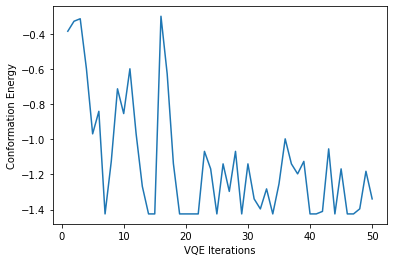

In [4]:
import matplotlib.pyplot as plt

figure = plt.figure()

plt.plot(counts, values)
plt.ylabel("Conformation Energy")
plt.xlabel("VQE Iterations")

plt.show()